In [1]:
import jax.numpy as jnp
from jax import random
from jax.scipy.special import logsumexp
from jax import grad

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#!/Users/asadh/mambaforge/bin/pip install matplotlib

## Linear Regression

Lets set up a linear regression problem and get samples from the likelihood function. First we produce the data

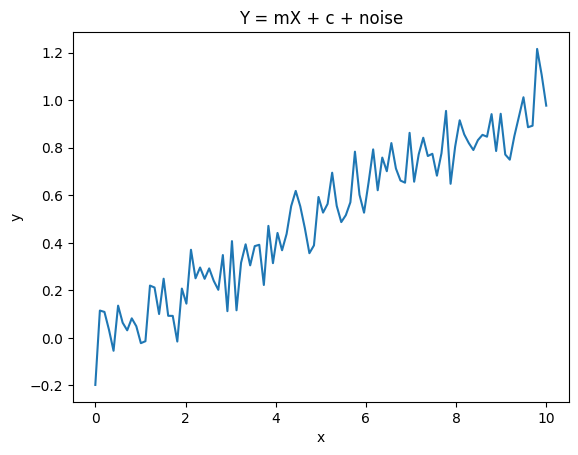

In [3]:
key = random.PRNGKey(0)

m = 0.1
c = 0
X = jnp.linspace(0,10,100)
noise_amount = 0.1
eps = noise_amount*random.normal(key, X.shape)

Y = m*X + c + eps

plt.plot(X,Y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Y = mX + c + noise")
plt.show()

### Linear Regressor Model

Here we create the model. All we need is a class that has a `logpdf` function that takes in a dictionary of data and outputs the logpdf

In [4]:
class LinearRegressor:
    def __init__(self, X, Y, noise=1):
        self.X = X
        self.Y = Y
        self.noise = noise

    def logpdf(self, x):
        Z = (self.Y - x['m']*self.X - x['c'])/self.noise
        return jnp.sum(-(Z**2))/2 

__Instantiate the model__

In [5]:
LR = LinearRegressor(X,Y,noise=noise_amount)  # Instantiate the model

Set starting point of the NUTS sampler to some point specified as a dictionary. Then initialize the NUTS sampler

In [45]:
from bayesian_inference import NUTS
import jax

initial_position = {'m':0.0, 'c':1.0} # starting point of the NUTS sampler
problem = NUTS(LR, initial_position)

__Run the results__

In [46]:
result = problem.run(1000)

Running the inference for 1000 samples


array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'm'}>]],
      dtype=object)

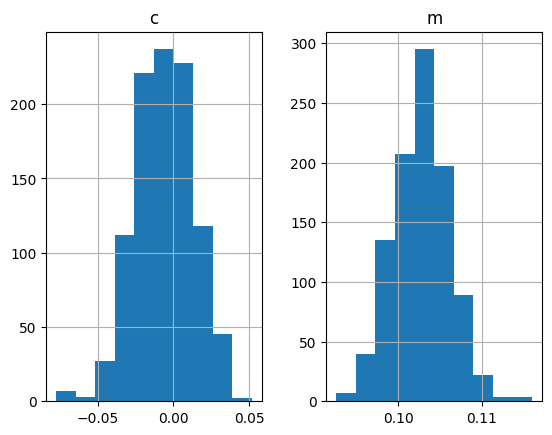

In [47]:
result.hist()

The chain will be returned as a dataframe. We can now create a traceplot and a histogram of the parameters

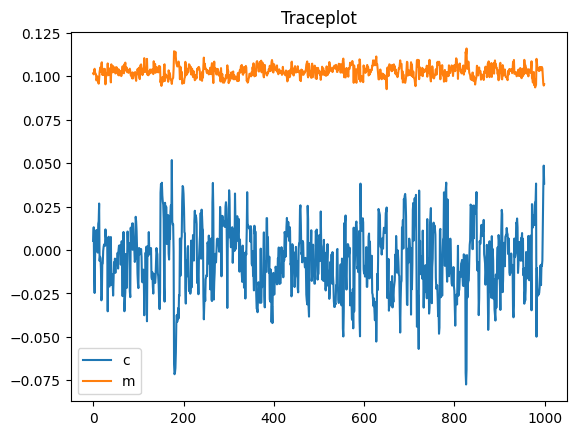

In [49]:
result.plot(title="Traceplot");

In [24]:
## Before running this install:
## pip install jax
## pip install jaxlib
## pip install blackjax

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
import pandas as pd

import blackjax

class NUTS:
    def __init__(self, likelihood, init_position, step_size=1e-3, inverse_mass_matrix=None, rng_key=None, warmup_steps=100):
        if rng_key is None:
            rng_key = jax.random.key(np.random.randint(2**32))
        self.likelihood = likelihood
        self.step_size = step_size
        self.rng_key = rng_key
        self.likelihood_func = lambda x: self.likelihood.logpdf(x)

        ## Set up the warmup for the HMC sampler
        warmup = blackjax.window_adaptation(blackjax.nuts, self.likelihood_func)
        rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
        (self._state_init, parameters), _ = warmup.run(warmup_key, init_position, num_steps=warmup_steps)

        self.kernel = jax.jit(blackjax.nuts(self.likelihood_func, **parameters).step)
        self.states = []

    def step(self, x):
        return self.kernel(x)

    def inference_loop(self, num_samples, sample_key=None):
        if sample_key is None:
            self.rng_key, sample_key = jax.random.split(self.rng_key, 2)

        print(f"Running the inference for {num_samples} samples")
        
        @jax.jit
        def one_step(state, rng_key):
            state, _ = self.kernel(rng_key, state)
            return state, state
    
        keys = jax.random.split(self.rng_key, num_samples)
        _, self.states = jax.lax.scan(one_step, self._state_init, keys)

        return self.states            

    def run(self, num_samples=100):
        self.states = None
        self.inference_loop(num_samples)
        return pd.DataFrame(self.states.position)
        

In [25]:
class mylike:
    def __init__(self):
        self.data = np.random.randn(1000)

    def logpdf(self, x):
        return jnp.sum(-0.5*(self.data - x['mu'])**2)

ML = mylike()

In [31]:
N = NUTS(ML, {'mu':3.0})

result = N.run(1000)

Running the inference for 1000 samples


array([[<Axes: title={'center': 'mu'}>]], dtype=object)

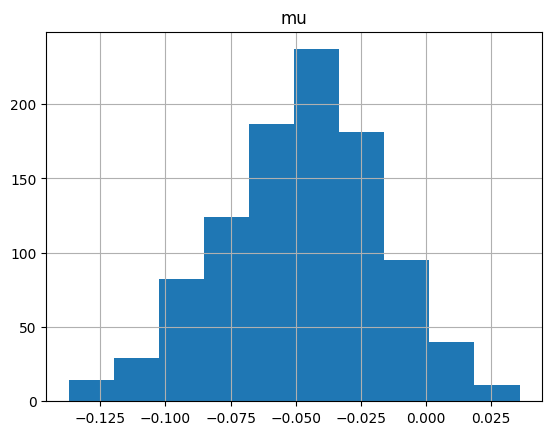

In [32]:
result.hist()

In [143]:
class SoftSphereLike:
    def __init__(self):
        pass

    def logpdf(self, x):
        return -beta*energy


class Proposal:
    def __init__(self, NN):
        self.NN = NN

    def propose(self, x):
        return NN.predict(x)

class ContinuousMHSampler:
    def __init__(self, likelihood_model):
        self.likelihood_model = likelihood_model
        pass

    def step(self, state):
        logpdf = self.likelihood_model.logpdf(state)
        new_state = self.propose(state)
        new_logpdf = self.likelihood_model.logpdf(new_state)
         while np.rand() > exp(new_logpdf - logpdf):
             return next_state
        return next_state

SS = SoftSphereLike(blah)
my_samp = Sampler(SS)

<Axes: >

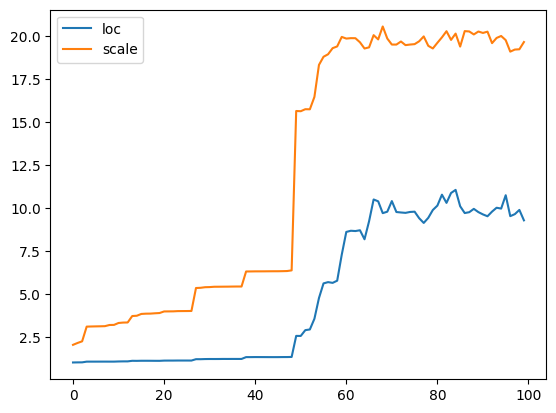

In [144]:
#type(state.position['loc'] )
import pandas as pd
df = pd.DataFrame(history)

df.plot()

In [142]:
import jax.numpy as jnp



class StateSpace:
    def __init__(self, ranges):
        self.ranges = ranges
        self.names = list(ranges.keys())
        self.transformation_functions = {}



StateSpace({'m':[-np.Inf, np.Inf], 'c': [-np.Inf, np.Inf]})





In [ ]:
def classify(x):
    if x[0] == -np.Inf:
        if x[1] == np.Inf:
            return 'Unbounded'
        else:
            return 'BoundedBelow'
    else:
        if x[1] == np.Inf:
            return 'BoundedAbove'
        else:
            return 'BoundedBoth'


class Unbounded:
    def __init__(self):
        pass

    def transform(self, x):
        return x

class BoundedBelow:
    def __init__(self, a):
        self.

    def transform(self, x):
        return x

In [ ]:
class MetropolisHastings:
    def __init__(self, 

In [17]:
a,b = [2,3]

In [19]:
import numpy as np

In [1]:
from bayesian_inference import MHSampler


